In [5]:
# INX Employee Performance Analysis -
# visualizations for your prediction results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("Visualization libraries imported successfully!")

Visualization libraries imported successfully!


In [9]:

PREDICTIONS_PATH = r'C:\Users\aksha\OneDrive\Documents\Asha\Projects\Employment_Performance_Analysis\Data\processed\employee_predictions.csv'
X_TEST_PATH = r"C:\Users\aksha\OneDrive\Documents\Asha\Projects\Employment_Performance_Analysis\Data\processed\X_test_selected.csv"
MODEL_PATH = r'C:\Users\aksha\OneDrive\Documents\Asha\Projects\Employment_Performance_Analysis\Source Code\models\best_model.pkl'  

FEATURE_IMPORTANCE_PATH = r'C:\Users\aksha\OneDrive\Documents\Asha\Projects\Employment_Performance_Analysis\Data\processed\feature_importance.csv'
MODEL_COMPARISON_PATH = r'C:\Users\aksha\OneDrive\Documents\Asha\Projects\Employment_Performance_Analysis\Data\processed\model_results.csv'

print("Configuration loaded!")


Configuration loaded!


In [10]:
# =============================================================================
# LOAD PREDICTION RESULTS
# =============================================================================

def load_prediction_results():
    """Load your prediction results and test data"""
    
    try:
        # Load main prediction results
        predictions_df = pd.read_csv(PREDICTIONS_PATH)
        print(f"✓ Prediction results loaded: {predictions_df.shape}")
        
        # Ensure we have the required columns
        required_cols = ['Predicted_Rating', 'Predicted_Category']
        missing_cols = [col for col in required_cols if col not in predictions_df.columns]
        
        if missing_cols:
            print(f"⚠️  Missing columns: {missing_cols}")
            # Add missing columns if needed
            if 'Predicted_Category' not in predictions_df.columns and 'Predicted_Rating' in predictions_df.columns:
                rating_map = {1: 'Poor', 2: 'Below Average', 3: 'Average', 4: 'Good', 5: 'Excellent'}
                predictions_df['Predicted_Category'] = predictions_df['Predicted_Rating'].map(rating_map)
                print("✓ Added Predicted_Category column")
        
        return predictions_df
        
    except FileNotFoundError:
        print(f"❌ Prediction results not found at: {PREDICTIONS_PATH}")
        print("Please run your prediction script first to generate results")
        return None

In [11]:
def load_additional_data():
    """Load additional data for enhanced visualizations"""
    
    feature_importance = None
    model_comparison = None
    model_features = None

    # Load feature importance if available
    if FEATURE_IMPORTANCE_PATH:
        try:
            feature_importance = pd.read_csv(FEATURE_IMPORTANCE_PATH)
            print("✓ Feature importance loaded")
        except FileNotFoundError:
            print("⚠️  Feature importance file not found")
    
    # Load model comparison if available
    if MODEL_COMPARISON_PATH:
        try:
            model_comparison = pd.read_csv(MODEL_COMPARISON_PATH)
            print("✓ Model comparison loaded")
        except FileNotFoundError:
            print("⚠️  Model comparison file not found")
    
    # Try to load model for feature importance extraction
    try:
        import joblib
        model = joblib.load(MODEL_PATH)
        if hasattr(model, 'feature_importances_'):
            X_test = pd.read_csv(X_TEST_PATH)
            model_features = pd.DataFrame({
                'feature': X_test.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            print("✓ Feature importance extracted from model")
    except Exception as e:
        print(f"ℹ  Could not extract feature importance from model: {e}")
    
    # Fix ambiguous return
    if feature_importance is not None and not feature_importance.empty:
        return feature_importance, model_comparison
    elif model_features is not None and not model_features.empty:
        return model_features, model_comparison
    else:
        return pd.DataFrame(), model_comparison

In [12]:
# Load all data
predictions_df = load_prediction_results()
feature_importance, model_comparison = load_additional_data()

✓ Prediction results loaded: (240, 26)
✓ Feature importance loaded
✓ Model comparison loaded
✓ Feature importance extracted from model


In [13]:
# =============================================================================
# 1. PREDICTION DISTRIBUTION VISUALIZATIONS
# =============================================================================

def create_prediction_distribution_plots(predictions_df):
    """Create comprehensive prediction distribution visualizations"""
    
    print("\n" + "="*50)
    print("CREATING PREDICTION DISTRIBUTION PLOTS...")
    print("="*50)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('INX Employee Performance - Prediction Distribution Analysis', 
                 fontsize=16, fontweight='bold')
    
    # Define colors
    colors = ['#FF6B6B', '#FFA726', '#FFEB3B', '#66BB6A', '#4CAF50']
    
    # 1. Rating Distribution Bar Chart
    rating_counts = predictions_df['Predicted_Rating'].value_counts().sort_index()
    bars = axes[0,0].bar(rating_counts.index, rating_counts.values, 
                        color=colors[:len(rating_counts)], alpha=0.8, edgecolor='black')
    axes[0,0].set_title('Distribution of Predicted Performance Ratings', 
                       fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Performance Rating')
    axes[0,0].set_ylabel('Number of Employees')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, rating_counts.values):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. Category Distribution Pie Chart
    category_counts = predictions_df['Predicted_Category'].value_counts()
    wedges, texts, autotexts = axes[0,1].pie(category_counts.values, labels=category_counts.index, 
                                            autopct='%1.1f%%', colors=colors[:len(category_counts)], 
                                            startangle=90)
    axes[0,1].set_title('Performance Rating Categories Distribution', 
                       fontsize=12, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_fontweight('bold')
    
    # 3. Prediction Statistics
    axes[1,0].axis('off')
    
    # Calculate statistics
    total_employees = len(predictions_df)
    avg_rating = predictions_df['Predicted_Rating'].mean()
    rating_std = predictions_df['Predicted_Rating'].std()
    
    stats_text = f"""PREDICTION STATISTICS

Total Employees Analyzed: {total_employees:,}

Average Predicted Rating: {avg_rating:.2f}
Standard Deviation: {rating_std:.2f}

Rating Breakdown:
"""
    
    for rating, count in rating_counts.items():
        percentage = (count / total_employees) * 100
        rating_name = {1: 'Poor', 2: 'Below Average', 3: 'Average', 4: 'Good', 5: 'Excellent'}[rating]
        stats_text += f"• {rating_name} ({rating}): {count:,} ({percentage:.1f}%)\n"
    
    # Add high/low performers
    high_performers = (predictions_df['Predicted_Rating'] >= 4).sum()
    low_performers = (predictions_df['Predicted_Rating'] <= 2).sum()
    
    stats_text += f"""
KEY INSIGHTS:
• High Performers (4-5): {high_performers:,} ({high_performers/total_employees*100:.1f}%)
• Low Performers (1-2): {low_performers:,} ({low_performers/total_employees*100:.1f}%)
• Retention Focus Needed: {low_performers:,} employees
"""
    
    axes[1,0].text(0.1, 0.9, stats_text, transform=axes[1,0].transAxes, 
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))
    
    # 4. Rating Trend Analysis (if Employee_ID exists)
    if 'Employee_ID' in predictions_df.columns:
        # Sample employees to show trend
        sample_size = min(50, len(predictions_df))
        sample_df = predictions_df.sample(sample_size).sort_values('Employee_ID')
        
        axes[1,1].plot(sample_df['Employee_ID'], sample_df['Predicted_Rating'], 
                      marker='o', linestyle='-', alpha=0.7, color='steelblue')
        axes[1,1].set_title(f'Performance Rating Pattern (Sample of {sample_size} employees)', 
                           fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Employee ID')
        axes[1,1].set_ylabel('Predicted Rating')
        axes[1,1].grid(True, alpha=0.3)
    else:
        # Show rating distribution histogram instead
        axes[1,1].hist(predictions_df['Predicted_Rating'], bins=5, 
                      color='steelblue', alpha=0.7, edgecolor='black')
        axes[1,1].set_title('Performance Rating Frequency', 
                           fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Performance Rating')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("✓ Prediction distribution plots created successfully")



CREATING PREDICTION DISTRIBUTION PLOTS...


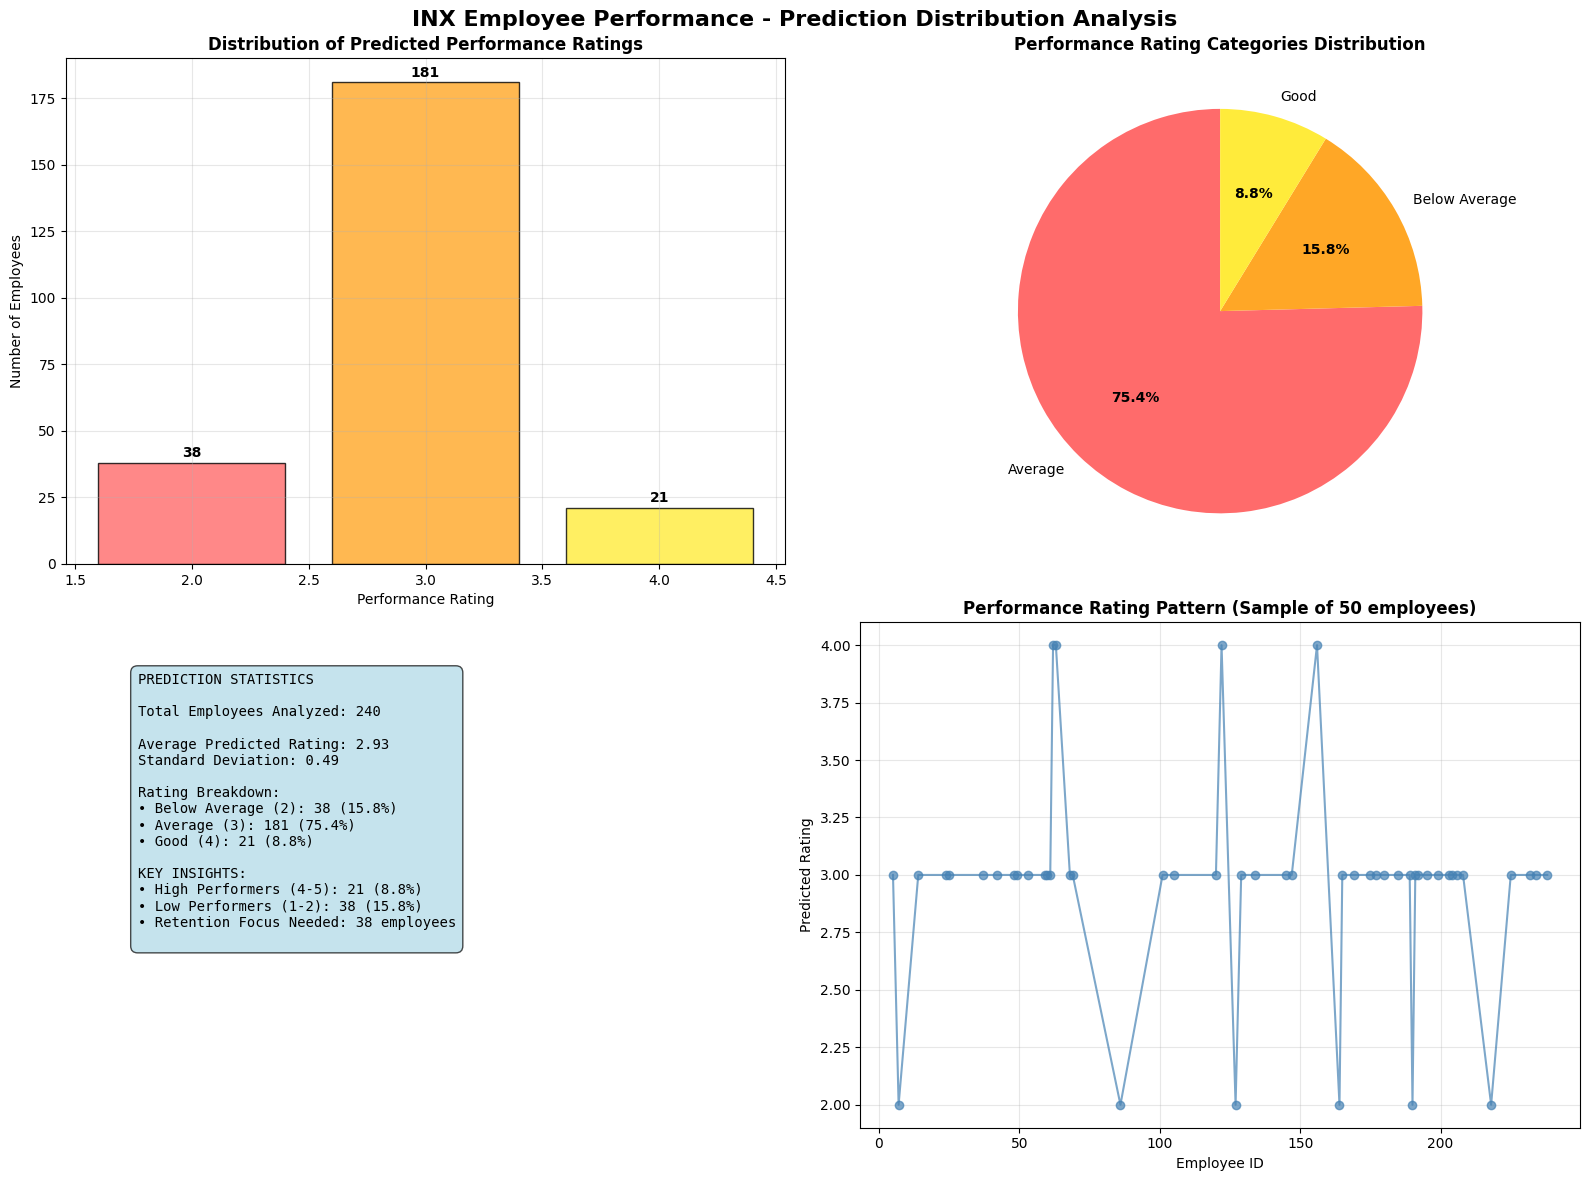

✓ Prediction distribution plots created successfully


In [14]:
# Create prediction distribution plots
create_prediction_distribution_plots(predictions_df)


CREATING FEATURE ANALYSIS PLOTS...


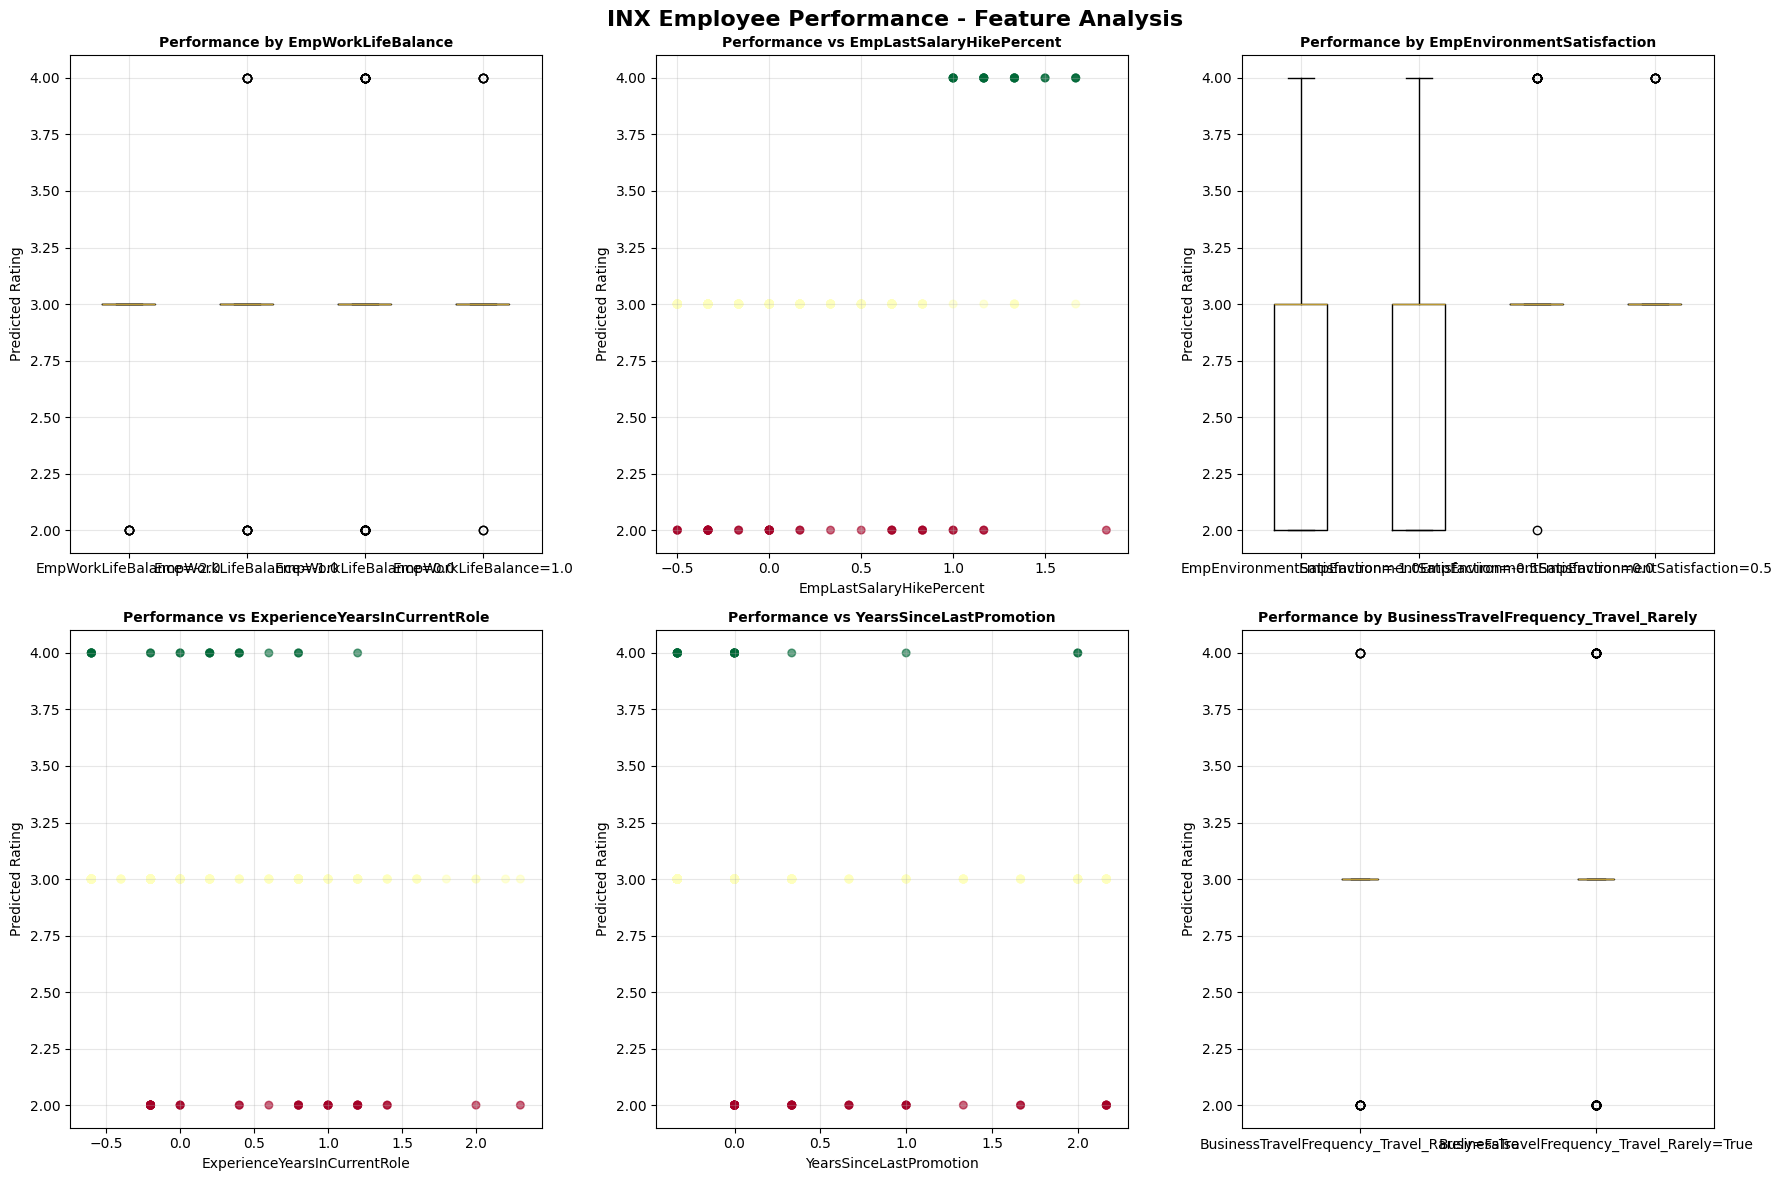

✓ Feature analysis plots created successfully


In [15]:
# =============================================================================
# 2. FEATURE ANALYSIS VISUALIZATIONS
# =============================================================================

def create_feature_analysis_plots(predictions_df):
    """Create feature-based analysis plots"""
    
    print("\n" + "="*50)
    print("CREATING FEATURE ANALYSIS PLOTS...")
    print("="*50)
    
    # Find key features in the data
    feature_cols = [col for col in predictions_df.columns 
                   if col not in ['Employee_ID', 'Predicted_Rating', 'Predicted_Category', 
                                'Actual_Rating', 'Actual_Category', 'Correct_Prediction']]
    
    if len(feature_cols) == 0:
        print("⚠️  No feature columns found for analysis")
        return
    
    # Create subplots
    n_plots = min(6, len(feature_cols))  # Show max 6 features
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('INX Employee Performance - Feature Analysis', 
                 fontsize=16, fontweight='bold')
    axes = axes.ravel()
    
    # Select key features to analyze
    key_features = []
    priority_features = ['EmpWorkLifeBalance', 'TrainingTimesLastYear', 'EmpLastSalaryHikePercent',
                        'Age', 'TotalWorkExperienceInYears', 'OverTime_Yes']
    
    # Add priority features first
    for feat in priority_features:
        if feat in feature_cols:
            key_features.append(feat)
    
    # Add other features if needed
    for feat in feature_cols:
        if feat not in key_features and len(key_features) < n_plots:
            key_features.append(feat)
    
    key_features = key_features[:n_plots]
    
    for i, feature in enumerate(key_features):
        if i >= n_plots:
            break
            
        # Check if feature is categorical (binary encoded) or continuous
        unique_vals = predictions_df[feature].nunique()
        
        if unique_vals <= 5:  # Categorical feature
            # Box plot for categorical features
            feature_groups = predictions_df.groupby(feature)['Predicted_Rating'].apply(list)
            
            box_data = [feature_groups[val] if val in feature_groups.index else [] 
                       for val in sorted(predictions_df[feature].unique())]
            box_labels = [f'{feature}={val}' for val in sorted(predictions_df[feature].unique())]
            
            axes[i].boxplot(box_data, labels=box_labels)
            axes[i].set_title(f'Performance by {feature}', fontsize=10, fontweight='bold')
            axes[i].set_ylabel('Predicted Rating')
            axes[i].grid(True, alpha=0.3)
            
        else:  # Continuous feature
            # Scatter plot for continuous features
            scatter = axes[i].scatter(predictions_df[feature], predictions_df['Predicted_Rating'],
                                    alpha=0.6, c=predictions_df['Predicted_Rating'], 
                                    cmap='RdYlGn', s=30)
            axes[i].set_title(f'Performance vs {feature}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Predicted Rating')
            axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(key_features), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("✓ Feature analysis plots created successfully")

# Create feature analysis plots
create_feature_analysis_plots(predictions_df)


CREATING DEPARTMENT AND ROLE ANALYSIS...


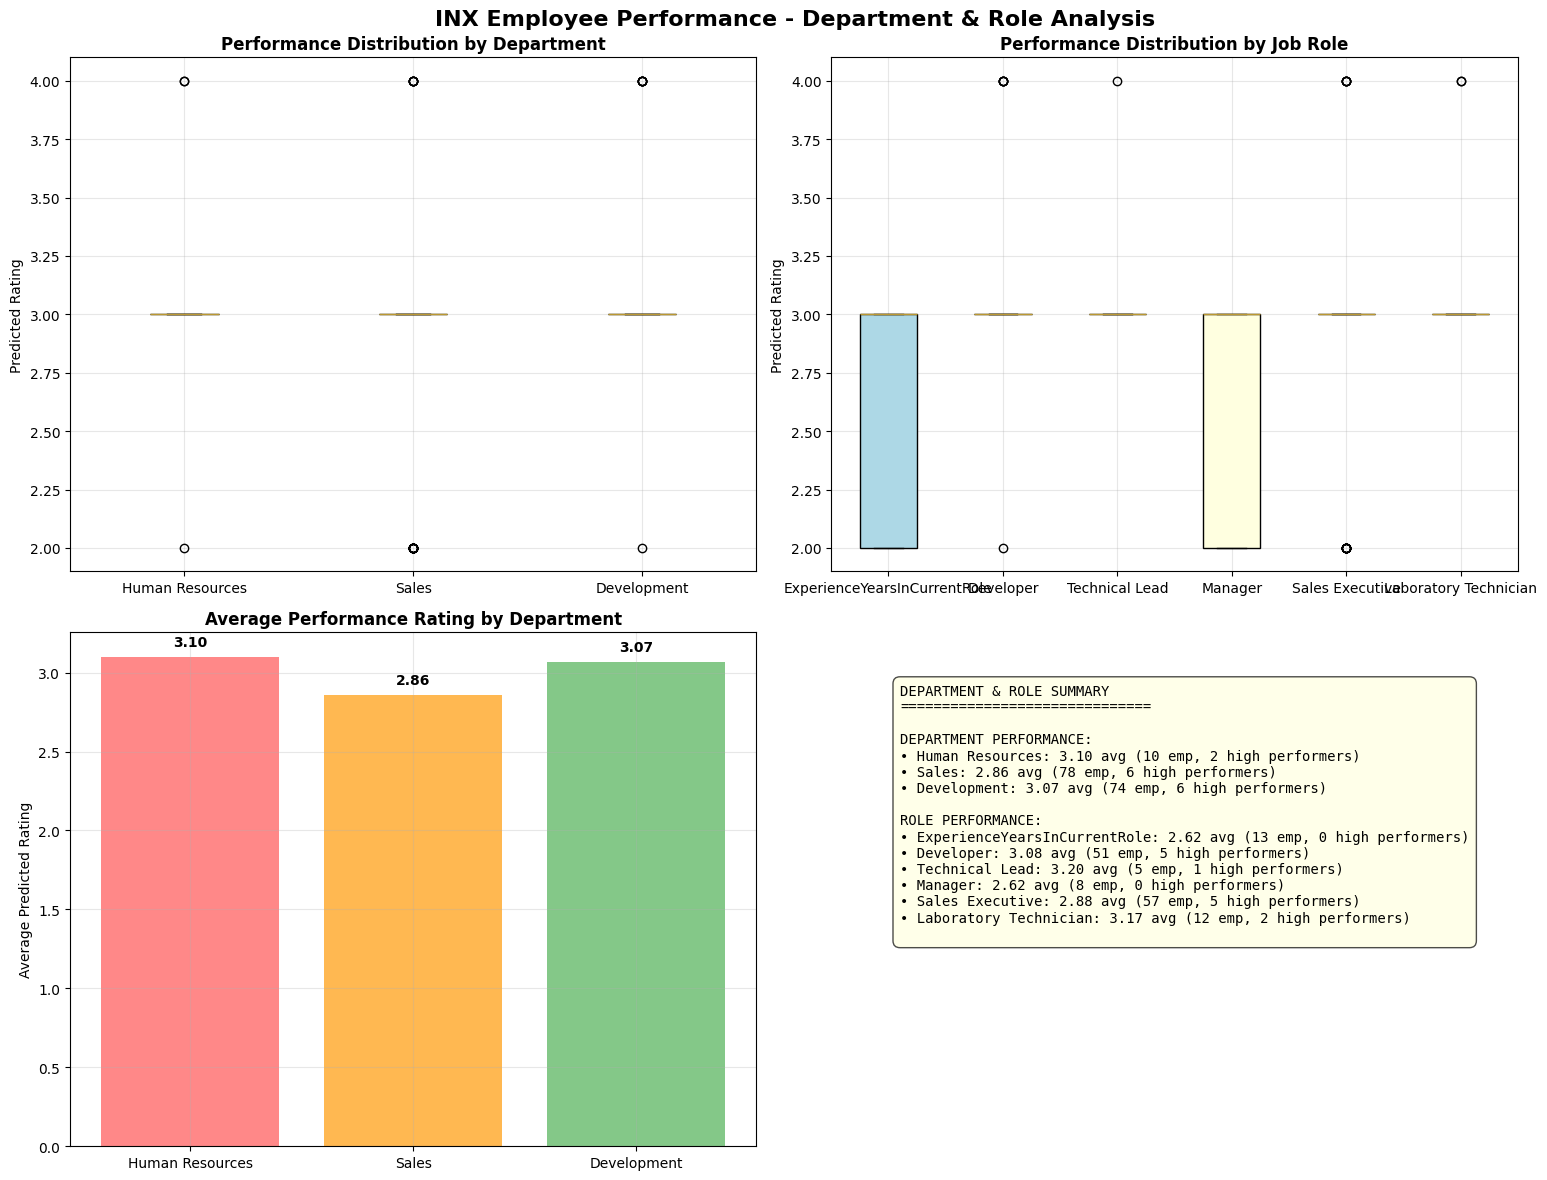

✓ Department and role analysis created successfully


In [16]:
# =============================================================================
# 3. DEPARTMENT AND ROLE ANALYSIS
# =============================================================================

def create_department_role_analysis(predictions_df):
    """Create department and role-wise performance analysis"""
    
    print("\n" + "="*50)
    print("CREATING DEPARTMENT AND ROLE ANALYSIS...")
    print("="*50)
    
    # Find department and role columns
    dept_cols = [col for col in predictions_df.columns if 'Department' in col]
    role_cols = [col for col in predictions_df.columns if 'Role' in col or 'JobRole' in col]
    
    if not dept_cols and not role_cols:
        print("⚠️  No department or role columns found")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('INX Employee Performance - Department & Role Analysis', 
                 fontsize=16, fontweight='bold')
    
    # 1. Department-wise Performance Distribution
    if dept_cols:
        dept_performance = {}
        for dept_col in dept_cols:
            dept_name = dept_col.replace('EmpDepartment_', '')
            dept_employees = predictions_df[predictions_df[dept_col] == 1]
            if len(dept_employees) > 0:
                dept_performance[dept_name] = dept_employees['Predicted_Rating'].tolist()
        
        if dept_performance:
            dept_names = list(dept_performance.keys())
            dept_ratings = list(dept_performance.values())
            
            box_plot = axes[0,0].boxplot(dept_ratings, labels=dept_names, patch_artist=True)
            axes[0,0].set_title('Performance Distribution by Department', fontsize=12, fontweight='bold')
            axes[0,0].set_ylabel('Predicted Rating')
            axes[0,0].grid(True, alpha=0.3)
            
            # Color the boxes
            colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
    else:
        axes[0,0].text(0.5, 0.5, 'No Department Data\nAvailable', 
                      ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Department Analysis')
    
    # 2. Role-wise Performance Distribution
    if role_cols:
        role_performance = {}
        for role_col in role_cols:
            role_name = role_col.replace('EmpJobRole_', '')
            role_employees = predictions_df[predictions_df[role_col] == 1]
            if len(role_employees) > 0:
                role_performance[role_name] = role_employees['Predicted_Rating'].tolist()
        
        if role_performance:
            role_names = list(role_performance.keys())
            role_ratings = list(role_performance.values())
            
            box_plot = axes[0,1].boxplot(role_ratings, labels=role_names, patch_artist=True)
            axes[0,1].set_title('Performance Distribution by Job Role', fontsize=12, fontweight='bold')
            axes[0,1].set_ylabel('Predicted Rating')
            axes[0,1].grid(True, alpha=0.3)
            
            # Color the boxes
            colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
    else:
        axes[0,1].text(0.5, 0.5, 'No Role Data\nAvailable', 
                      ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Role Analysis')
    
    # 3. Average Performance by Department
    if dept_cols:
        dept_avg_performance = []
        dept_names_clean = []
        
        for dept_col in dept_cols:
            dept_name = dept_col.replace('EmpDepartment_', '')
            dept_employees = predictions_df[predictions_df[dept_col] == 1]
            if len(dept_employees) > 0:
                avg_rating = dept_employees['Predicted_Rating'].mean()
                dept_avg_performance.append(avg_rating)
                dept_names_clean.append(dept_name)
        
        if dept_avg_performance:
            bars = axes[1,0].bar(dept_names_clean, dept_avg_performance, 
                               color=['#FF6B6B', '#FFA726', '#66BB6A'], alpha=0.8)
            axes[1,0].set_title('Average Performance Rating by Department', fontsize=12, fontweight='bold')
            axes[1,0].set_ylabel('Average Predicted Rating')
            axes[1,0].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, avg in zip(bars, dept_avg_performance):
                axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                              f'{avg:.2f}', ha='center', va='bottom', fontweight='bold')
    else:
        axes[1,0].axis('off')
    
    # 4. Performance Summary Table
    axes[1,1].axis('off')
    
    summary_text = "DEPARTMENT & ROLE SUMMARY\n" + "="*30 + "\n\n"
    
    if dept_cols:
        summary_text += "DEPARTMENT PERFORMANCE:\n"
        for dept_col in dept_cols:
            dept_name = dept_col.replace('EmpDepartment_', '')
            dept_employees = predictions_df[predictions_df[dept_col] == 1]
            if len(dept_employees) > 0:
                avg_rating = dept_employees['Predicted_Rating'].mean()
                count = len(dept_employees)
                high_perf = (dept_employees['Predicted_Rating'] >= 4).sum()
                summary_text += f"• {dept_name}: {avg_rating:.2f} avg ({count} emp, {high_perf} high performers)\n"
        summary_text += "\n"
    
    if role_cols:
        summary_text += "ROLE PERFORMANCE:\n"
        for role_col in role_cols:
            role_name = role_col.replace('EmpJobRole_', '')
            role_employees = predictions_df[predictions_df[role_col] == 1]
            if len(role_employees) > 0:
                avg_rating = role_employees['Predicted_Rating'].mean()
                count = len(role_employees)
                high_perf = (role_employees['Predicted_Rating'] >= 4).sum()
                summary_text += f"• {role_name}: {avg_rating:.2f} avg ({count} emp, {high_perf} high performers)\n"
    
    axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    print("✓ Department and role analysis created successfully")

# Create department and role analysis
create_department_role_analysis(predictions_df)


CREATING FEATURE IMPORTANCE VISUALIZATION...


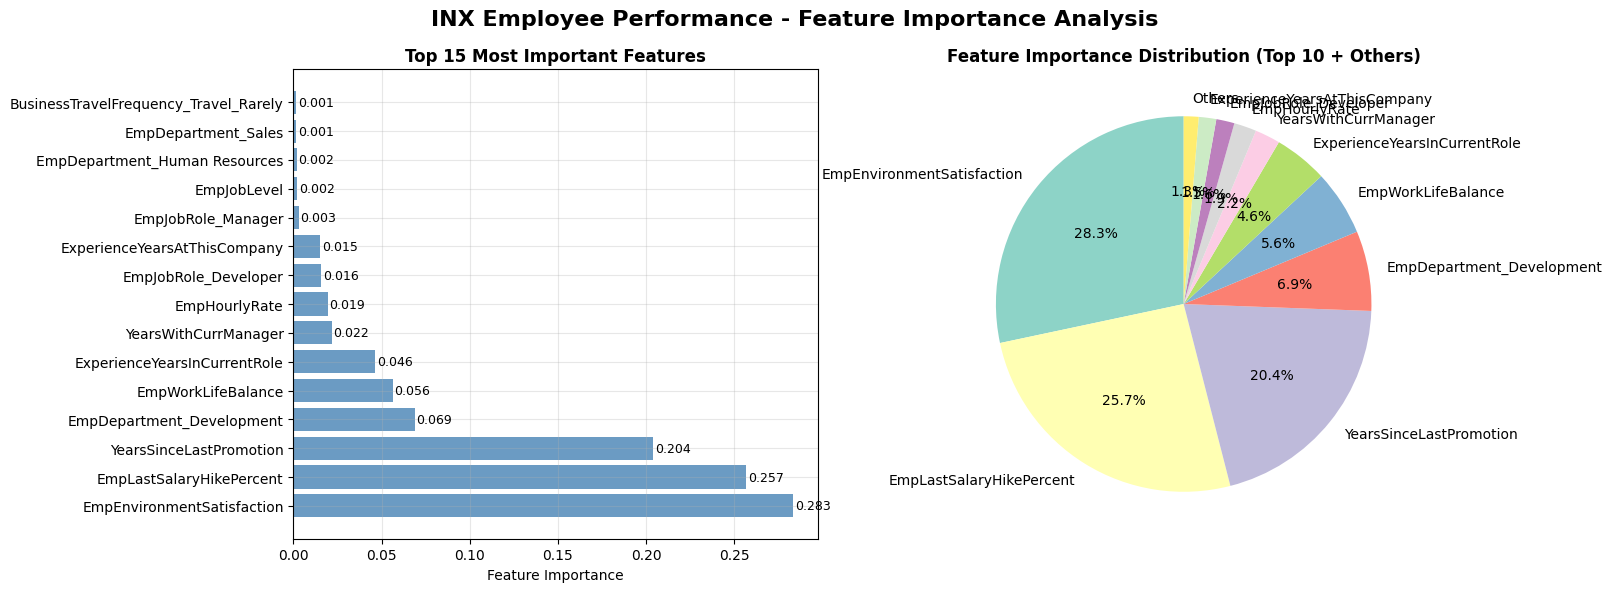

✓ Feature importance visualization created successfully


In [17]:
# =============================================================================
# 4. FEATURE IMPORTANCE VISUALIZATION
# =============================================================================

def create_feature_importance_plot(feature_importance):
    """Create feature importance visualization"""
    
    if feature_importance is None:
        print("⚠️  No feature importance data available")
        return
    
    print("\n" + "="*50)
    print("CREATING FEATURE IMPORTANCE VISUALIZATION...")
    print("="*50)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('INX Employee Performance - Feature Importance Analysis', 
                 fontsize=16, fontweight='bold')
    
    # Sort by importance
    top_features = feature_importance.head(15)  # Top 15 features
    
    # 1. Horizontal bar chart
    y_pos = np.arange(len(top_features))
    axes[0].barh(y_pos, top_features['importance'], color='steelblue', alpha=0.8)
    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(top_features['feature'])
    axes[0].set_xlabel('Feature Importance')
    axes[0].set_title('Top 15 Most Important Features', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (_, row) in enumerate(top_features.iterrows()):
        axes[0].text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
                    va='center', fontsize=9)
    
    # 2. Pie chart for top 10 features
    top_10 = feature_importance.head(10)
    others_importance = feature_importance.iloc[10:]['importance'].sum()
    
    pie_data = list(top_10['importance']) + [others_importance]
    pie_labels = list(top_10['feature']) + ['Others']
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))
    
    axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
               colors=colors, startangle=90)
    axes[1].set_title('Feature Importance Distribution (Top 10 + Others)', 
                     fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    print("✓ Feature importance visualization created successfully")

# Create feature importance plot
create_feature_importance_plot(feature_importance)

In [19]:
# =============================================================================
# 5. INTERACTIVE PLOTLY VISUALIZATIONS
# =============================================================================

def create_interactive_plots(predictions_df):
    """Create interactive Plotly visualizations"""
    
    print("\n" + "="*50)
    print("CREATING INTERACTIVE VISUALIZATIONS...")
    print("="*50)
    
    # 1. Interactive Performance Distribution
    fig1 = px.histogram(predictions_df, x='Predicted_Rating', 
                        title='Interactive Performance Rating Distribution',
                       color='Predicted_Rating',
                       color_discrete_sequence=px.colors.qualitative.Set3)
    fig1.update_layout(showlegend=False)
    fig1.show()

    
    # 2. Interactive Scatter Plot (if we have continuous features)
    continuous_features = []
    for col in predictions_df.columns:
        if predictions_df[col].dtype in ['int64', 'float64'] and predictions_df[col].nunique() > 10:
            if col not in ['Employee_ID', 'Predicted_Rating', 'Actual_Rating']:
                continuous_features.append(col)
    
    if len(continuous_features) >= 2:
        fig2 = px.scatter(predictions_df, 
                         x=continuous_features[0], 
                         y=continuous_features[1],
                         color='Predicted_Rating',
                         title=f'Interactive: {continuous_features[0]} vs {continuous_features[1]}',
                         color_continuous_scale='RdYlGn',
                         hover_data=['Predicted_Category'])
        fig2.show()
    
    # 3. Interactive Category Distribution
    category_counts = predictions_df['Predicted_Category'].value_counts()
    fig3 = px.pie(values=category_counts.values, names=category_counts.index,
                  title='Interactive Performance Categories Distribution')
    fig3.show()
    
    print("✓ Interactive visualizations created successfully")

# Create interactive plots
try:
    create_interactive_plots(predictions_df)
except ImportError:
    print("⚠️  Plotly not available for interactive plots. Skipping...")


CREATING INTERACTIVE VISUALIZATIONS...


✓ Interactive visualizations created successfully


In [20]:
# =============================================================================
# SUMMARY REPORT
# =============================================================================

def generate_visualization_summary(predictions_df):
    """Generate a comprehensive visualization summary"""
    
    print("\n" + "="*60)
    print("📊 VISUALIZATION SUMMARY REPORT")
    print("="*60)
    
    total_employees = len(predictions_df)
    
    print(f"📈 ANALYSIS COMPLETED FOR {total_employees:,} EMPLOYEES")
    print("-" * 50)
    
    # Rating distribution
    rating_counts = predictions_df['Predicted_Rating'].value_counts().sort_index()
    print("🎯 PERFORMANCE RATING DISTRIBUTION:")
    for rating, count in rating_counts.items():
        rating_name = {1: 'Poor', 2: 'Below Average', 3: 'Average', 4: 'Good', 5: 'Excellent'}[rating]
        percentage = (count / total_employees) * 100
        print(f"   {rating_name} ({rating}): {count:,} employees ({percentage:.1f}%)")
    
    # Key insights
    high_performers = (predictions_df['Predicted_Rating'] >= 4).sum()
    low_performers = (predictions_df['Predicted_Rating'] <= 2).sum()
    avg_rating = predictions_df['Predicted_Rating'].mean()
    
    print(f"\n🔍 KEY INSIGHTS:")
    print(f"   • Average Rating: {avg_rating:.2f}/5.0")
    print(f"   • High Performers (4-5): {high_performers:,} ({high_performers/total_employees*100:.1f}%)")
    print(f"   • Low Performers (1-2): {low_performers:,} ({low_performers/total_employees*100:.1f}%)")
    print(f"   • Employees needing attention: {low_performers:,}")
    print(f"   • Star performers for recognition: {(predictions_df['Predicted_Rating'] == 5).sum():,}")
    
    print(f"\n✅ VISUALIZATIONS CREATED:")
    print("   ✓ Prediction Distribution Analysis")
    print("   ✓ Feature Analysis Plots")
    print("   ✓ Department & Role Analysis")
    if feature_importance is not None:
        print("   ✓ Feature Importance Visualization")
    print("   ✓ Interactive Plotly Charts")
    
    print(f"\n📁 DATA SOURCES USED:")
    print(f"   • Predictions: {PREDICTIONS_PATH}")
    print(f"   • Model: {MODEL_PATH}")
    if feature_importance is not None:
        print("   • Feature Importance: Extracted from model")
    
    print("\n" + "="*60)
    print("🎉 VISUALIZATION ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*60)



In [21]:
generate_visualization_summary(predictions_df)


📊 VISUALIZATION SUMMARY REPORT
📈 ANALYSIS COMPLETED FOR 240 EMPLOYEES
--------------------------------------------------
🎯 PERFORMANCE RATING DISTRIBUTION:
   Below Average (2): 38 employees (15.8%)
   Average (3): 181 employees (75.4%)
   Good (4): 21 employees (8.8%)

🔍 KEY INSIGHTS:
   • Average Rating: 2.93/5.0
   • High Performers (4-5): 21 (8.8%)
   • Low Performers (1-2): 38 (15.8%)
   • Employees needing attention: 38
   • Star performers for recognition: 0

✅ VISUALIZATIONS CREATED:
   ✓ Prediction Distribution Analysis
   ✓ Feature Analysis Plots
   ✓ Department & Role Analysis
   ✓ Feature Importance Visualization
   ✓ Interactive Plotly Charts

📁 DATA SOURCES USED:
   • Predictions: C:\Users\aksha\OneDrive\Documents\Asha\Projects\Employment_Performance_Analysis\Data\processed\employee_predictions.csv
   • Model: C:\Users\aksha\OneDrive\Documents\Asha\Projects\Employment_Performance_Analysis\Source Code\models\best_model.pkl
   • Feature Importance: Extracted from model

🎉 